# Current code and solution

In [3]:
""" 
Optimization of the sky for OVRO scheduler

Walter Max-Moerbeck, Oct 30, 2023
"""

#pip install import-ipynb
import ipynb.fs.full.sky_optimizer as SO

from datetime import date, timedelta
#from py40m.calendar import datetime_to_mjd
import pickle
import time

In [4]:
# observation parameters:
lst_start = 0.0
lst_int = 1.76
sun_jd = 60248.0 # Oct 30, 2023
date_tag = '30102023'

# Load the source and regions optimized in a previous stage
with open('region_optimizer_results.dat', 'rb') as file:
    sources = pickle.load(file)
    regions = pickle.load(file)
file.close()

N_iter = 0
total_minimum = 1.0e100
t0 = time.time()

initial_order, initial_total_time, initial_order_lst, lst_start = SO.order_regions_slew_time(regions, 
                                                                                             sources,
                                                                                             lst_start=lst_start,
                                                                                             lst_obs_win=5./60.,
                                                                                             za_t=0.0,
                                                                                             az_t=180.0,
                                                                                             sun_jd=sun_jd)


print ('initial best slew estimate with lst_start', lst_start, 'total_time', initial_total_time)
print ('with region order:', initial_order)

sun ra dec= 226.73344783529663 -18.081762056554513
region 0 sun_angle 123.83209778990762 34.3784 73.8256
region 1 sun_angle 112.3785012825411 111.549 79.1919
region 2 sun_angle 94.14420550695256 222.12 76.0197
region 3 sun_angle 104.5129271120882 301.379 77.8786
region 4 sun_angle 126.69864758755625 17.5536 68.0948
region 5 sun_angle 131.28849791986326 72.3471 63.5358
region 6 sun_angle 115.37960907919714 110.473 71.3433
region 7 sun_angle 101.20733062769396 149.697 65.565
region 8 sun_angle 81.90368428036096 219.191 63.6103
region 9 sun_angle 88.69122961656477 250.533 68.9442
region 10 sun_angle 100.66732805067508 301.87 66.1228
region 11 sun_angle 114.11535119514994 337.652 69.7744
region 12 sun_angle 140.9771585333635 18.3625 49.8067
region 13 sun_angle 135.44822347094774 41.2404 62.4685
region 14 sun_angle 133.91633138689156 85.3174 53.2067
region 15 sun_angle 118.58940699255784 113.469 50.3692
region 16 sun_angle 109.32029219899988 128.729 55.5728
region 17 sun_angle 90.8032946266

In [5]:
best_time = initial_total_time
best_regions = initial_order[:]

#puse un num random para que corriera
if best_time <= 1000:#length:
    N_iter = 0
else:
    N_iter = 0
    
for i in range(N_iter):

    updated_regions, updated_time, delta =\
                                        SO.modify_path_keep_cal(regions,
                                                       initial_order,
                                                       lst_start,
                                                       sources,
                                                       wait=True,
                                                       za_t=0.0,
                                                       az_t=180.0)

    delta = updated_time -initial_total_time
    if updated_time < initial_total_time:
        initial_order = updated_regions[:]
        initial_total_time = updated_time

    if initial_total_time < best_time:
        best_time = initial_total_time
        best_regions = updated_regions[:]#

    if i % 100 == 0:
        print ('for iter ', i, 'initial_time =', initial_total_time, 'updated_time =', updated_time, 'best_time=', best_time, 'delta=', delta)

t1 = time.time()
print ('Total time for solution  ', t1 - t0, ' sec')
print ('Total time for solution  ', (t1 - t0)/60., ' min')
print ('Total time for solution  ', (t1 - t0)/3600., ' hour')

Total time for solution   1143.1321980953217  sec
Total time for solution   19.052203301588694  min
Total time for solution   0.3175367216931449  hour


In [6]:
# simulate the observation
report = SO.simulate_regions_final(regions,
                   best_regions,
                   lst_start,
                   sources,
                   wait=True)

za, az, t_obs, t_slew, t_wait, lst = SO.report_stats(report)

#take away the observing time from the last region which is just added to give the slew time and wait time
total = sum(t_obs) + sum(t_slew) + sum(t_wait)
print ('best obtained time =', total, 'with region order', best_regions)


--------------------------------------------------
Schedule summary
number lst za   az   t_obs  t_slew  t_wait
        h  deg  deg  h      h       h
53	0.11648	34.90	269.64	0.34009	0.11648	0.00000
54	0.79148	28.44	261.64	0.56339	0.02428	0.31063
39	1.69932	34.15	290.26	0.62817	0.01481	0.32963
142	2.64603	38.06	54.07	0.64981	0.31855	0.00000
15	3.32042	46.50	52.24	0.79681	0.02458	0.00000
29	4.13645	47.42	63.16	0.78166	0.01922	0.00000
61	4.93293	47.52	89.90	0.43898	0.01482	0.00000
76	5.38497	42.05	120.71	0.42950	0.01306	0.00000
92	5.83497	43.53	155.19	0.25296	0.02050	0.00000
131	6.11777	51.77	171.95	0.34454	0.02985	0.00000
116	6.47205	51.01	189.31	0.45954	0.00974	0.00000
75	6.95248	35.19	217.67	0.28546	0.02089	0.00000
91	7.27059	43.64	230.33	0.52338	0.03265	0.00000
141	7.83860	47.03	207.88	0.64981	0.04463	0.00000
115	8.51960	50.84	198.75	0.27692	0.03120	0.00000
130	8.81793	55.70	197.39	0.30118	0.02141	0.00000
114	9.13306	48.38	183.43	0.48901	0.01395	0.00000
129	9.63561	51.28	173.78	0.2901

In [14]:
#Para obtener un estimado del limite de t_wait entre regiones:
import numpy as np

print(max(t_wait))
print(min(t_wait))
print(np.mean(t_wait))

0.32962960023783094
0.0
0.00847441871932396


In [17]:
total

96.8833556758526

In [19]:
# if this solution is best save with starndard name
#if total < total_minimum:
#    SO.save_results(best_regions, lst, sky_optimization_results_file)


# Save the results of sky optimization. 
#SO.save_results(sorted_regions, sorted_regions_lst, sky_optimization_results_file)

# simulate the observation
#report = SO.simulate_regions_observation(regions,
#                                         sorted_regions,
#                                         lst_start,
#                                         sources,
#                                         wait=True)

#za, az, t_obs, t_slew, t_wait = SO.report_stats(report)

# Dada las fuentes visibles, buscamos la mejor ruta de observación:

In [ ]:
sources['NGC7027']
#for region in regions:
    #print(regions[region])
regions[0]

for m in range(137):
    for n in range(len(regions[m]['sources'])):
        if regions[m]['sources'][n] == 'J0217+7349': 
            print(m)

In [ ]:
## PARA VISUALIZAR QUE FUENTES SON VISIBLES DADO UN LST FIJO

lst_fijos = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'] #list(map(str,range(0, 2)))
visible_sources_per_lst=[]

for lst in list(range(0,25)):
    lista = []
    for name_fuente in sources:
        for k in range(len(sources[name_fuente]['obs_range'])):
            if sources[name_fuente]['obs_range'][k][0] <= lst and lst <= sources[name_fuente]['obs_range'][k][1]:
                #print(f"la función {name_fuente} si es visible.")
                lista.append(name_fuente)
                
                #for m in range(137):
                #    for n in range(len(regions[m]['sources'])):
                #        if regions[m]['sources'][n] == name_fuente: 
                #            lista.append([name_fuente, m])
    visible_sources_per_lst.append(lista)

visible_sources = {lst_fijos: visible_sources_per_lst for (lst_fijos,visible_sources_per_lst) in zip(lst_fijos,visible_sources_per_lst) }
print(len(visible_sources['0']))
#visible_sources

In [15]:
#for p in lst_fijos:
#    print(len(visible_sources[p]))

In [24]:
## CONSTRUCCIÓN DE LA MATRIZ DE TIEMPOS ENTRE REGIONES

## **1° strategy:** Genetic Algorithm

In [466]:
import random
def genetic_algorithm_sky(order_opt, tam_poblacion, prob_mutacion, num_generaciones):
    t0 = time.time()
    
    report = SO.simulate_regions_final(regions, order_opt, lst_start, sources, wait=True)   #entrega [region_number,za_c, az_c, t_obs, t_slew, t_wait, obs_lst]
    minimum_obstime = SO.report_obs_time(report)
    
    # Creating a random starting population
    unique_order_opt = list(dict.fromkeys(order_opt))
    N=len(order_opt)
    M=len(unique_order_opt) #136 porque no considera las regiones 110 y 125.

    poblacion = []
    for _ in range(tam_poblacion):
        updated_regions, updated_time, delta =\
                                        SO.modify_path_keep_cal(regions,
                                                       unique_order_opt,
                                                       lst_start,
                                                       sources,
                                                       wait=True,
                                                       za_t=0.0,
                                                       az_t=180.0)
        poblacion.append(updated_regions)

    for generacion in range(num_generaciones):
        for i in range(len(poblacion)):
            new_order = poblacion[i]
            new_report = SO.simulate_regions_final(regions, new_order, lst_start, sources, wait=True)
        
            new_t_obs = SO.report_obs_time(new_report)
            new_t_wait = SO.report_wait_time(new_report)
            new_t_slew = SO.report_slew_time(new_report)
        
            #if obstime is reduced we have new optimum and others new conditions 
            
            #if new_t_obs < minimum_obstime:
            #if new_t_obs < minimum_obstime and (new_t_slew + new_t_wait)<15:
            if (new_t_obs + new_t_slew + new_t_wait)<88:
                minimum_obstime = new_t_obs
                order_opt = new_order
                        
        nueva_poblacion = order_opt[:]
        while len(nueva_poblacion) < tam_poblacion:
        
            padre1, padre2 = random.sample(poblacion[:int(0.5*tam_poblacion)], 2)
            punto_cruce = random.randint(0, M)
            hijo = padre1[:punto_cruce] + [x for x in padre2 if x not in padre1[:punto_cruce]]
                
            if random.random() < prob_mutacion:
                idx1, idx2 = random.sample(range(0,M), 2)
                hijo[idx1], hijo[idx2] = hijo[idx2], hijo[idx1]
            nueva_poblacion.append(hijo)
        
            nuevo_orden = nueva_poblacion[-1]
            nuevo_report = SO.simulate_regions_final(regions, nuevo_orden, lst_start, sources, wait=True) 
            nuevo_t_obs = SO.report_wait_time(nuevo_report)
            nuevo_t_wait = SO.report_wait_time(nuevo_report)
            nuevo_t_slew = SO.report_slew_time(nuevo_report)
        
            #if nuevo_t_obs < minimum_obstime:
            #if nuevo_t_obs < minimum_obstime and (nuevo_t_slew + nuevo_t_wait)<15:
            if (nuevo_t_obs + nuevo_t_slew + nuevo_t_wait)<88:
                minimum_obstime = nuevo_t_obs
                order_opt = nuevo_orden

        
    #print( 'Final length = ', minimum_obstime)
    print( 'optimum travel order =  ', order_opt)
    print( 'estamos trabajando con n° de fuentes igual a ', len(order_opt))
    print( '  \n')
    
    final_report = SO.simulate_regions_final(regions, order_opt, lst_start, sources, wait=True) 
    t_obs = SO.report_obs_time(final_report)
    t_wait = SO.report_wait_time(final_report)
    t_slew = SO.report_slew_time(final_report)
    print( 't_obs = ', t_obs)
    print( 't_slew = ', t_slew)
    print( 't_wait = ', t_wait)
    print( '  \n')
        
    tf = time.time()
    time_taken = tf-t0
    print("minutos", time_taken/60)
    print("horas", time_taken/3600)

In [467]:
order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
genetic_algorithm_sky(order, 500, 0.8, 100)

optimum travel order =   ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '72', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '102', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
estamos trabajando con n° de fuentes igual a  136
  

t_obs =  76.17748115041752
t_slew =  7.782392096489399
t_wait =  28.7720575

#### Haciendo pruebas:

In [320]:
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '19', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '142', '28', '44', '16', '6', '7', '1', '17', '141', '60', '93', '77', '136', '140', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '138', '24', '12', '72', '137', '85', '103', '135', '88', '87', '142', '59', '117', '133', '90', '73', '58', '41', '26', '62', '141', '95', '79', '112', '136', '140', '65', '97', '111', '96', '64', '80', '47', '48', '139', '33', '102', '55', '35', '138', '56', '137', '105', '104', '119', '134', '118', '142', '74', '89', '57', '132', '45', '30', '31', '141', '63', '113', '128', '136', '140', '127', '46', '126', '51', '36', '21', '32', '139', '49', '50', '34', '20', '138', '40', '137', '139', '37']

#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '60', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '24', '105', '12', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '112', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '34', '20', '40', '37']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '6', '7', '1', '17', '60', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '24', '105', '12', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '112', '19', '97', '111', '96', '64', '80', '47', '48', '33', '102', '55', '35', '56', '104', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '36', '21', '32', '49', '50', '34', '20', '40', '37']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '6', '58', '1', '17', '60', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '24', '105', '12', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '7', '41', '26', '62', '95', '79', '112', '19', '97', '111', '96', '36', '80', '47', '48', '33', '102', '55', '35', '56', '104', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '64', '21', '32', '49', '50', '34', '20', '40', '37']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '19', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '87', '28', '44', '16', '6', '7', '1', '17', '60', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '24', '12', '72', '85', '103', '135', '88', '42', '57', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '112', '65', '97', '111', '96', '64', '80', '47', '48', '33', '102', '55', '35', '56', '105', '104', '119', '134', '118', '74', '89', '59', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '36', '21', '32', '49', '50', '34', '20', '40', '37']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '19', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '103', '5', '14', '27', '87', '28', '44', '16', '6', '7', '1', '17', '60', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '24', '12', '72', '85', '4', '135', '88', '42', '57', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '112', '65', '97', '111', '96', '64', '80', '47', '48', '33', '102', '55', '35', '56', '105', '104', '119', '134', '118', '74', '89', '59', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '36', '21', '32', '49', '50', '34', '20', '40', '37']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '112', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '12', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '20', '40']

#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '112', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '20', '12']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '112', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '87', '59', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '20', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '35', '12']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '112', '93', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '59', '87', '117', '133', '90', '73', '58', '41', '26', '62', '95', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '12', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '20']

#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '58', '14', '27', '42', '28', '44', '16', '91', '7', '1', '17', '112', '93', '77', '66', '81', '98', '82', '96', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '59', '87', '117', '133', '90', '73', '5', '41', '26', '62', '95', '79', '60', '19', '97', '111', '67', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '12', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '20']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '58', '17', '112', '95', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '34', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '59', '87', '117', '133', '90', '73', '1', '41', '26', '62', '93', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '12', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '20']
#order = ['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '6', '141', '115', '130', '114', '129', '94', '136', '140', '65', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '28', '44', '16', '91', '7', '58', '17', '112', '95', '77', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '20', '86', '71', '24', '105', '40', '72', '85', '103', '135', '88', '59', '87', '117', '133', '90', '73', '1', '41', '26', '62', '93', '79', '60', '19', '97', '111', '96', '64', '36', '47', '48', '33', '102', '55', '35', '56', '104', '37', '70', '119', '134', '118', '74', '89', '57', '132', '12', '45', '30', '31', '63', '113', '128', '127', '46', '126', '51', '80', '21', '32', '49', '50', '34']

#order = ['104', '54', '4', '88', '5', '15', '132', '41', '116', '92', '131', '75', '6', '76', '130', '115', '114', '129', '112', '95', '136', '34', '127', '97', '126', '67', '137', '37', '124', '84', '68', '69', '108', '107', '123', '38', '101', '122', '52', '106', '121', '12', '56', '53', '13', '14', '26', '119', '72', '27', '73', '28', '44', '16', '17', '58', '31', '128', '64', '1', '19', '66', '80', '81', '99', '82', '109', '83', '2', '22', '139', '3', '20', '70', '105', '71', '24', '40', '138', '103', '135', '11', '55', '74', '118', '91', '117', '133', '29', '77', '0', '142', '62', '93', '113', '61', '140', '65', '79', '46', '111', '21', '47', '48', '50', '35', '39', '85', '102', '86', '25', '87', '134', '42', '89', '57', '59', '90', '60', '141', '45', '30', '94', '63', '7', '18', '33', '96', '98', '51', '36', '10', '9', '8', '32', '49']
#order = ['104', '54', '4', '88', '5', '15', '132', '41', '116', '92', '131', '75', '6', '76', '130', '115', '114', '129', '79', '33', '136', '65', '127', '97', '126', '67', '137', '37', '124', '84', '68', '69', '108', '107', '123', '38', '101', '122', '52', '106', '121', '12', '56', '53', '13', '14', '26', '119', '72', '27', '141', '28', '44', '16', '17', '58', '31', '128', '64', '1', '19', '66', '80', '81', '99', '82', '109', '83', '2', '22', '139', '3', '20', '70', '105', '71', '24', '40', '138', '103', '135', '11', '55', '74', '118', '91', '117', '133', '29', '77', '0', '142', '62', '93', '113', '61', '140', '34', '95', '46', '112', '21', '47', '48', '50', '35', '39', '85', '102', '86', '25', '87', '134', '42', '89', '57', '59', '90', '60', '73', '45', '30', '94', '63', '7', '18', '111', '96', '98', '51', '36', '10', '9', '8', '32', '49']
#order = ['104', '54', '4', '88', '5', '15', '132', '41', '116', '92', '131', '75', '6', '76', '130', '115', '114', '129', '79', '33', '136', '65', '127', '97', '126', '67', '137', '37', '124', '84', '68', '69', '108', '107', '123', '38', '101', '122', '52', '106', '121', '12', '102', '53', '13', '14', '26', '119', '72', '27', '141', '28', '44', '16', '17', '58', '31', '128', '64', '1', '19', '66', '80', '81', '99', '82', '109', '83', '2', '22', '139', '3', '20', '70', '105', '71', '24', '40', '138', '103', '135', '11', '55', '74', '118', '91', '117', '133', '29', '77', '0', '142', '62', '93', '113', '61', '140', '34', '95', '46', '112', '21', '47', '48', '50', '35', '39', '85', '56', '86', '25', '87', '134', '42', '89', '57', '59', '90', '60', '73', '45', '30', '94', '63', '7', '18', '111', '96', '98', '51', '36', '10', '9', '8', '32', '49']

#order = ['88', '27', '53', '54', '4', '0', '1', '116', '91', '74', '25', '5', '75', '76', '115', '130', '129', '113', '128', '64', '111', '96', '127', '126', '51', '21', '22', '37', '124', '108', '83', '85', '69', '84', '123', '107', '122', '101', '52', '106', '121', '24', '13', '41', '26', '14', '73', '118', '90', '42', '29', '28', '44', '30', '17', '58', '142', '15', '6', '33', '81', '80', '97', '98', '82', '99', '109', '68', '137', '139', '10', '49', '39', '70', '86', '40', '138', '87', '105', '102', '71', '38', '55', '72', '134', '117', '59', '60', '16', '7', '45', '63', '47', '79', '94', '93', '77', '61', '62', '95', '112', '3', '31', '48', '50', '35', '20', '11', '12', '56', '104', '103', '135', '119', '133', '57', '89', '132', '141', '131', '92', '114', '46', '136', '140', '18', '19', '34', '65', '66', '67', '36', '9', '2', '8', '32']
#order = ['38', '27', '53', '54', '118', '133', '92', '132', '141', '6', '91', '5', '115', '76', '130', '60', '129', '113', '112', '64', '128', '79', '34', '126', '51', '21', '37', '22', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '11', '135', '119', '14', '13', '26', '4', '42', '29', '28', '44', '30', '17', '58', '142', '15', '1', '19', '127', '80', '111', '82', '98', '99', '109', '68', '139', '137', '10', '49', '102', '70', '39', '24', '138', '87', '86', '105', '103', '41', '55', '89', '134', '90', '73', '117', '74', '7', '61', '63', '114', '31', '95', '94', '45', '62', '46', '96', '81', '35', '32', '48', '50', '20', '0', '25', '3', '56', '104', '71', '88', '72', '59', '57', '40', '16', '116', '131', '75', '93', '77', '140', '136', '18', '33', '66', '65', '97', '67', '36', '9', '2', '8', '47']

#order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '25', '58', '41', '119', '134', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '71', '70', '55', '24', '138', '86', '105', '103', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '13', '56', '104', '87', '135', '88', '72', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']

report = SO.simulate_regions_final(regions, order, lst_start, sources, wait=True)
new_t_obs = SO.report_obs_time(report)
new_t_wait = SO.report_wait_time(report)
new_t_slew = SO.report_slew_time(report)
print(new_t_obs, new_t_wait, new_t_slew)
print(new_t_obs+new_t_wait+new_t_slew)

76.21139198486722 5.239081593561818 7.28144958451916
88.7319231629482


In [182]:
# simulate the observation
report = SO.simulate_regions_final(regions,
                   order,
                   lst_start,
                   sources,
                   wait=True)

za, az, t_obs, t_slew, t_wait, lst = SO.report_stats(report)

#take away the observing time from the last region which is just added to give the slew time and wait time
total = sum(t_obs) + sum(t_slew) + sum(t_wait)
print ('best obtained time =', total)


--------------------------------------------------
Schedule summary
number lst za   az   t_obs  t_slew  t_wait
        h  deg  deg  h      h       h
53	0.11648	34.90	269.64	0.34009	0.11648	0.00000
54	0.79148	28.44	261.64	0.56339	0.02428	0.31063
39	1.69932	34.15	290.26	0.62817	0.01481	0.32963
142	2.64603	38.06	54.07	0.64981	0.31855	0.00000
15	3.32042	46.50	52.24	0.79681	0.02458	0.00000
29	4.13645	47.42	63.16	0.78166	0.01922	0.00000
61	4.93293	47.52	89.90	0.43898	0.01482	0.00000
76	5.38497	42.05	120.71	0.42950	0.01306	0.00000
92	5.83497	43.53	155.19	0.25296	0.02050	0.00000
131	6.11777	51.77	171.95	0.34454	0.02985	0.00000
116	6.47205	51.01	189.31	0.45954	0.00974	0.00000
75	6.95248	35.19	217.67	0.28546	0.02089	0.00000
6	7.50679	34.13	1.09	0.48528	0.26885	0.00000
141	8.24936	48.20	211.55	0.64981	0.25729	0.00000
115	8.92919	52.71	206.05	0.27681	0.03002	0.00000
130	9.22886	57.44	204.13	0.30157	0.02286	0.00000
114	9.54423	49.02	191.45	0.48871	0.01380	0.00000
129	10.04751	51.08	181.46	0.29056	

In [357]:
with open('region_optimizer_results.dat', 'rb') as file:
    sources = pickle.load(file)
    regions = pickle.load(file)
file.close()
sources['NGC7027']

{'ra': 316.757,
 'dec': 42.2362,
 'pointing': 1,
 'obs_range': [[0.0, 2.5087108013937285],
  [15.80487804878049, 19.4006968641115],
  [22.82926829268293, 24.0]]}

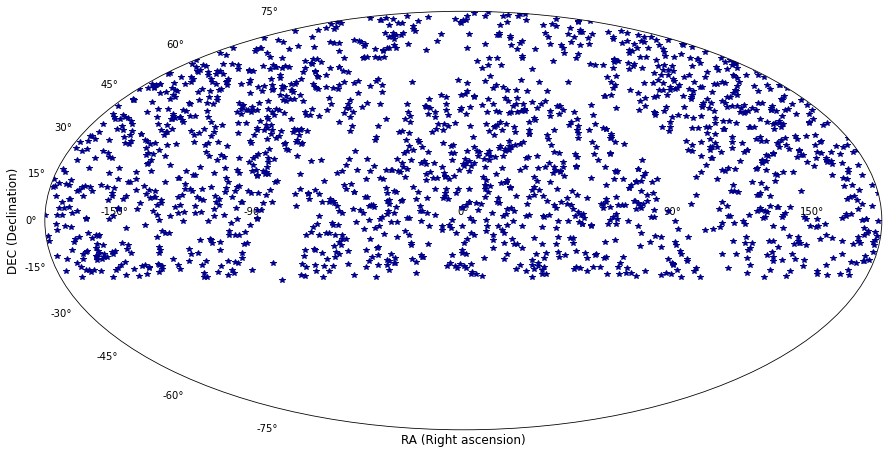

In [443]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

def plot_coordinates(ra_values, dec_values):
    # Crear una figura
    fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'}, figsize=(15, 12))

    # Convertir grados a radianes para cada elemento de las listas
    ra_rad = [val * u.deg.to(u.rad) for val in ra_values]
    dec_rad = [val * u.deg.to(u.rad) for val in dec_values]

    # Dibujar puntos en las coordenadas 'ra' y 'dec'
    ax.plot(ra_rad, dec_rad, '*', markersize=6, color='darkblue')#color='darkolivegreen')

    # Configuraciones adicionales del gráfico
    ax.grid(False)
    ax.set_xlabel('RA (Right ascension)', fontsize=12)
    ax.set_ylabel('DEC (Declination)', fontsize=12)
    ax.set_title('')
    
    #for ylabel in ax.get_yticklabels():
    #    ylabel.set_visible(False)
        
    #for xlabel in ax.get_xticklabels():
    #    xlabel.set_visible(False)
    
    ax.set_xticklabels(['-150°','','-90°','','','0°','','','90°','','150°'],color='black')
    #ax.set_yticklabels(['-75°','','-45°','','-15°','0°','15°','','45°','','75°'],color='black')
    
    # Mostrar la figura
    plt.show()

# Obtener listas de valores 'ra' y 'dec'

#ra_values = [source_info['ra'] for source_info in sources.values()]
for p in range(len(ra_values)):
    if ra_values[p] >=180:
        ra_values[p]=ra_values[p]-360
ra_values
dec_values = [source_info['dec'] for source_info in sources.values()]

# Crear la imagen de monitoreo astronómico con los valores 'ra' y 'dec'
plot_coordinates(ra_values, dec_values)

In [29]:
lst=25
#lista_1=[]
for k in range(len(regions)):
    for p in range(len(regions[k]['obs_range'])):
        if regions[k]['obs_range'][p][0] <= lst and lst <= regions[k]['obs_range'][p][1]:
            print("En la región", k)
        #lista_1.append(regions[k]['obs_range'][p][0])
        #lista_1.append(regions[k]['obs_range'][p][1])
#unique_lista_1 = list(dict.fromkeys(lista_1))
#unique_lista_1.sort()
#print(len(unique_lista_1))
#unique_lista_1

In [42]:
lst_fijos = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'] #list(map(str,range(0, 2)))
visible_regions_per_lst=[]

for lst in list(range(0,25)):
    lista = []
    for k in range(len(regions)):
        for p in range(len(regions[k]['obs_range'])):
            if regions[k]['obs_range'][p][0] <= lst and lst <= regions[k]['obs_range'][p][1]:
                lista.append(k)
                
            #for m in range(137):
            #    for n in range(len(regions[m]['sources'])):
            #        if regions[m]['sources'][n] == name_fuente: 
            #            lista.append([name_fuente, m])
    visible_regions_per_lst.append(lista)

visible_regions = {lst_fijos: visible_regions_per_lst for (lst_fijos,visible_regions_per_lst) in zip(lst_fijos,visible_regions_per_lst) }
#print(len(visible_regions['0']))

In [44]:
regions[0]['obs_range']

[[0.0, 9.273106323835997], [19.6636553161918, 24.0]]

In [48]:
for num_region in range(143):
    largo=0
    if num_region in visible_regions['8'] and num_region in visible_regions['9']:# and num_region in visible_regions['10']:
        print("region: ", num_region)
        print("ventana de visibilidad: ",regions[num_region]['obs_range'])
        for p in range(len(regions[num_region]['obs_range'])):
            largo = largo + (regions[num_region]['obs_range'][p][1] - regions[num_region]['obs_range'][p][0])
        print("largo de visibilidad: ", largo)
        print("\n")

region:  0
ventana de visibilidad:  [[0.0, 9.273106323835997], [19.6636553161918, 24.0]]
largo de visibilidad:  13.609451007644196


region:  1
ventana de visibilidad:  [[3.185545517720639, 14.543432939541347]]
largo de visibilidad:  11.357887421820708


region:  2
ventana de visibilidad:  [[7.87213342599027, 20.230715774843638]]
largo de visibilidad:  12.358582348853368


region:  5
ventana de visibilidad:  [[0.0, 9.856845031271716], [23.082696316886725, 24.0]]
largo de visibilidad:  10.77414871438499


region:  6
ventana de visibilidad:  [[2.268241834607366, 12.79221681723419]]
largo de visibilidad:  10.523974982626823


region:  7
ventana de visibilidad:  [[5.2703266157053505, 15.794301598332174]]
largo de visibilidad:  10.523974982626823


region:  14
ventana de visibilidad:  [[0.0, 3.3356497567755383], [7.038220986796386, 10.523974982626823], [23.91660875608061, 24.0]]
largo de visibilidad:  6.904794996525366


region:  26
ventana de visibilidad:  [[0.6838082001389854, 3.335649756

In [49]:
print(best_regions)

['53', '54', '39', '142', '15', '29', '61', '76', '92', '131', '116', '75', '91', '141', '115', '130', '114', '129', '94', '136', '140', '19', '8', '2', '9', '10', '3', '11', '22', '69', '68', '84', '108', '124', '123', '107', '101', '122', '106', '121', '138', '25', '13', '137', '0', '4', '5', '14', '27', '42', '142', '28', '44', '16', '6', '7', '1', '17', '141', '60', '93', '77', '136', '140', '66', '81', '98', '82', '67', '99', '109', '83', '52', '18', '139', '38', '70', '86', '71', '138', '24', '12', '72', '137', '85', '103', '135', '88', '87', '142', '59', '117', '133', '90', '73', '58', '41', '26', '62', '141', '95', '79', '112', '136', '140', '65', '97', '111', '96', '64', '80', '47', '48', '139', '33', '102', '55', '35', '138', '56', '137', '105', '104', '119', '134', '118', '142', '74', '89', '57', '132', '45', '30', '31', '141', '63', '113', '128', '136', '140', '127', '46', '126', '51', '36', '21', '32', '139', '49', '50', '34', '20', '138', '40', '137', '139', '37']


# Local Search

In [469]:
import random
import copy
import time

def local_search_multi_objective(regions, order_opt, lst_start, sources, tam_poblacion, prob_mutacion, num_generaciones):
    t0 = time.time()
    def evaluate_order(order):
        report = simulate_regions_final(regions, order, lst_start, sources, wait=True)
        t_obs = report_obs_time(report)
        t_wait = report_wait_time(report)
        t_slew = report_slew_time(report)
        return t_obs, t_wait, t_slew

    def is_better(new_objectives, current_objectives):
        return all(new_obj < current_obj for new_obj, current_obj in zip(new_objectives, current_objectives))

    current_objectives = evaluate_order(order_opt)

    for generacion in range(num_generaciones):
        for i in range(len(order_opt)):
            for j in range(i + 1, len(order_opt)):
                new_order = copy.deepcopy(order_opt)
                new_order[i], new_order[j] = new_order[j], new_order[i]

                new_objectives = evaluate_order(new_order)

                if is_better(new_objectives, current_objectives):
                    order_opt = new_order
                    current_objectives = new_objectives

        # Mutación
        for _ in range(tam_poblacion):
            i, j = random.sample(range(len(order_opt)), 2)
            new_order = copy.deepcopy(order_opt)
            new_order[i], new_order[j] = new_order[j], new_order[i]

            new_objectives = evaluate_order(new_order)

            if is_better(new_objectives, current_objectives):
                order_opt = new_order
                current_objectives = new_objectives

    print('optimum travel order =  ', order_opt)
    print('estamos trabajando con n° de fuentes igual a ', len(order_opt))
    print('\n')

    final_report = simulate_regions_final(regions, order_opt, lst_start, sources, wait=True)
    t_obs, t_wait, t_slew = report_obs_time(final_report), report_wait_time(final_report), report_slew_time(final_report)
    print('t_obs = ', t_obs)
    print('t_slew = ', t_slew)
    print('t_wait = ', t_wait)
    
    tf = time.time()
    print('time taken:', tf-t0)

In [471]:
import random
import copy
import time

def local_search_multi_objective_batch(regions, order_opt, lst_start, sources, tam_poblacion, prob_mutacion, num_generaciones, batch_size=5):
    t0 = time.time()

    def evaluate_order(order):
        report = SO.simulate_regions_final(regions, order, lst_start, sources, wait=True)
        t_obs = SO.report_obs_time(report)
        t_wait = SO.report_wait_time(report)
        t_slew = SO.report_slew_time(report)
        return t_obs, t_wait, t_slew

    def is_better(new_objectives, current_objectives):
        return all(new_obj < current_obj for new_obj, current_obj in zip(new_objectives, current_objectives))

    current_objectives = evaluate_order(order_opt)

    for generacion in range(num_generaciones):
        for i in range(0, len(order_opt), batch_size):
            batch = order_opt[i:i + batch_size]
            random.shuffle(batch)
            new_order = copy.deepcopy(order_opt)
            new_order[i:i + batch_size] = batch

            new_objectives = evaluate_order(new_order)

            if is_better(new_objectives, current_objectives):
                order_opt = new_order
                current_objectives = new_objectives

        # Mutación
        for _ in range(tam_poblacion):
            i, j = random.sample(range(len(order_opt)), 2)
            new_order = copy.deepcopy(order_opt)
            new_order[i], new_order[j] = new_order[j], new_order[i]

            new_objectives = evaluate_order(new_order)

            if is_better(new_objectives, current_objectives):
                order_opt = new_order
                current_objectives = new_objectives

    print('optimum travel order =  ', order_opt)
    print('estamos trabajando con n° de fuentes igual a ', len(order_opt))
    print('\n')

    final_report = SO.simulate_regions_final(regions, order_opt, lst_start, sources, wait=True)
    t_obs, t_wait, t_slew = SO.report_obs_time(final_report), SO.report_wait_time(final_report), SO.report_slew_time(final_report)
    print('t_obs = ', t_obs)
    print('t_slew = ', t_slew)
    print('t_wait = ', t_wait)
    
    tf = time.time()
    print('time taken:', (tf-t0)/60, 'min')

# Define las funciones report_obs_time, report_wait_time, report_slew_time, y simulate_regions_final aquí

# Asegúrate de tener las funciones necesarias para tu problema específico.

In [474]:
# Ahora puedes llamar a la función local_search_multi_objective_batch con tus parámetros

order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
local_search_multi_objective_batch(regions, order, lst_start, sources, tam_poblacion=1000, prob_mutacion=0.8, num_generaciones=200, batch_size=5)

optimum travel order =   ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
estamos trabajando con n° de fuentes igual a  136


t_obs =  76.21192333280806
t_slew =  7.46358052920869
t_wait =  5.05642181679

In [473]:
t_obs =  76.21192333280806
t_slew =  7.46358052920869
t_wait =  5.056421816798294
print(t_obs+t_slew+t_wait)

88.73192567881503


In [ ]:
import random
import copy
import time

def multi_objective_local_search(regions, order_opt, lst_start, sources, tam_poblacion, prob_mutacion, num_generaciones, weight_wait=0.3):
    t0 = time.time()

    def evaluate_order(order):
        report = SO.simulate_regions_final(regions, order, lst_start, sources, wait=True)
        t_obs = SO.report_obs_time(report)
        t_wait = SO.report_wait_time(report)
        t_slew = SO.report_slew_time(report)
        return t_obs, t_wait, t_slew

    def calculate_cost(t_wait, t_slew, weight_wait):
        # Una función simple que combina t_wait y t_slew
        return weight_wait * t_wait + (1 - weight_wait) * t_slew

    def is_better(new_cost, current_cost):
        # Busca minimizar la función de costo
        return new_cost < current_cost

    current_t_obs, current_t_wait, current_t_slew = evaluate_order(order_opt)
    current_cost = calculate_cost(current_t_wait, current_t_slew, weight_wait)

    for generacion in range(num_generaciones):
        for i in range(len(order_opt)):
            for j in range(i + 1, len(order_opt)):
                new_order = copy.deepcopy(order_opt)
                new_order[i], new_order[j] = new_order[j], new_order[i]

                new_t_obs, new_t_wait, new_t_slew = evaluate_order(new_order)
                new_cost = calculate_cost(new_t_wait, new_t_slew, weight_wait)

                if is_better(new_cost, current_cost):
                    order_opt = new_order
                    current_t_obs, current_t_wait, current_t_slew = new_t_obs, new_t_wait, new_t_slew
                    current_cost = new_cost

        # Mutación
        for _ in range(tam_poblacion):
            i, j = random.sample(range(len(order_opt)), 2)
            new_order = copy.deepcopy(order_opt)
            new_order[i], new_order[j] = new_order[j], new_order[i]

            new_t_obs, new_t_wait, new_t_slew = evaluate_order(new_order)
            new_cost = calculate_cost(new_t_wait, new_t_slew, weight_wait)

            if is_better(new_cost, current_cost):
                order_opt = new_order
                current_t_obs, current_t_wait, current_t_slew = new_t_obs, new_t_wait, new_t_slew
                current_cost = new_cost

    print('optimum travel order =  ', order_opt)
    print('estamos trabajando con n° de fuentes igual a ', len(order_opt))
    print('\n')

    final_report = SO.simulate_regions_final(regions, order_opt, lst_start, sources, wait=True)
    t_obs, t_wait, t_slew = SO.report_obs_time(final_report), SO.report_wait_time(final_report), SO.report_slew_time(final_report)
    print('t_obs = ', t_obs)
    print('t_slew = ', t_slew)
    print('t_wait = ', t_wait)
    
    tf = time.time()
    print('time taken:', (tf-t0)/60, 'min')

# Define las funciones report_obs_time, report_wait_time, report_slew_time, y simulate_regions_final aquí

# Asegúrate de tener las funciones necesarias para tu problema específico.

# Ahora puedes llamar a la función multi_objective_local_search con tus parámetros
#order = ['104', '54', '4', '88', '5', '15', '132', '41', '116', '92', '131', '75', '6', '76', '130', '115', '114', '129', '79', '33', '136', '65', '127', '97', '126', '67', '137', '37', '124', '84', '68', '69', '108', '107', '123', '38', '101', '122', '52', '106', '121', '12', '56', '53', '13', '14', '26', '119', '72', '27', '141', '28', '44', '16', '17', '58', '31', '128', '64', '1', '19', '66', '80', '81', '99', '82', '109', '83', '2', '22', '139', '3', '20', '70', '105', '71', '24', '40', '138', '103', '135', '11', '55', '74', '118', '91', '117', '133', '29', '77', '0', '142', '62', '93', '113', '61', '140', '34', '95', '46', '112', '21', '47', '48', '50', '35', '39', '85', '102', '86', '25', '87', '134', '42', '89', '57', '59', '90', '60', '73', '45', '30', '94', '63', '7', '18', '111', '96', '98', '51', '36', '10', '9', '8', '32', '49']

order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']
multi_objective_local_search(regions, order, lst_start, sources, tam_poblacion=1000, prob_mutacion=0.5, num_generaciones=50, weight_wait=0.4)

In [315]:
t_obs =  76.21139198486722
t_slew =  7.28144958451916
t_wait =  5.239081593561818
print(t_obs+t_slew+t_wait)

88.7319231629482


In [311]:
order_guardado =['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']

In [458]:
# simulate the observation
order = ['26', '53', '38', '54', '27', '141', '91', '74', '116', '132', '59', '5', '75', '76', '115', '130', '114', '129', '128', '95', '79', '112', '127', '98', '51', '35', '22', '37', '124', '108', '83', '101', '69', '84', '123', '107', '122', '121', '52', '85', '106', '12', '13', '135', '119', '58', '41', '118', '142', '44', '60', '28', '16', '7', '6', '14', '42', '15', '1', '19', '97', '111', '126', '81', '82', '99', '109', '68', '137', '21', '49', '139', '86', '70', '55', '24', '138', '87', '103', '105', '102', '10', '0', '90', '73', '89', '133', '117', '29', '46', '30', '31', '63', '113', '94', '77', '45', '62', '64', '80', '96', '48', '136', '8', '50', '20', '39', '3', '25', '56', '104', '71', '88', '72', '134', '57', '40', '4', '61', '131', '92', '93', '17', '32', '140', '18', '33', '65', '66', '34', '67', '36', '9', '2', '11', '47']

report = SO.simulate_regions_final(regions,
                   order,
                   lst_start,
                   sources,
                   wait=True)

za, az, t_obs, t_slew, t_wait, lst = SO.report_stats(report)

#take away the observing time from the last region which is just added to give the slew time and wait time
total = sum(t_obs) + sum(t_slew) + sum(t_wait)
print ('best obtained time =', total)


--------------------------------------------------
Schedule summary
number lst za   az   t_obs  t_slew  t_wait
        h  deg  deg  h      h       h
26	0.14825	38.31	67.61	0.46081	0.14825	0.00000
53	0.78953	42.16	-85.18	0.77214	0.18047	0.00000
38	1.58970	40.21	-65.80	0.31408	0.02803	0.00000
54	1.95229	41.98	-87.08	0.98541	0.04851	0.00000
27	3.10532	27.51	61.04	0.28592	0.16761	0.00000
141	3.59017	59.49	126.67	0.64981	0.07106	0.12787
91	4.26875	34.28	157.03	0.53029	0.02877	0.00000
74	4.86491	32.14	188.45	0.66654	0.01154	0.05433
116	5.58244	50.90	171.79	0.45671	0.05099	0.00000
132	6.06416	59.48	203.57	0.31964	0.02501	0.00000
59	6.42540	24.70	217.69	0.42205	0.04159	0.00000
5	6.98726	32.03	334.86	1.02176	0.13982	0.00000
75	8.13207	44.76	237.86	0.28292	0.12305	0.00000
76	8.45538	28.46	200.66	0.46779	0.04039	0.00000
115	8.94265	52.84	206.47	0.27679	0.01947	0.00000
130	9.24234	57.50	204.34	0.30158	0.02290	0.00000
114	9.55771	49.05	191.71	0.48870	0.01379	0.00000
129	10.06101	51.08	181.71	0.290

In [448]:
lst_fijos = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'] #list(map(str,range(0, 2)))
visible_regions_per_lst=[]

for lst in list(range(0,25)):
    lista = []
    for k in range(len(regions)):
        for p in range(len(regions[k]['obs_range'])):
            if regions[k]['obs_range'][p][0] <= lst and lst <= regions[k]['obs_range'][p][1]:
                lista.append(k)
                
            #for m in range(137):
            #    for n in range(len(regions[m]['sources'])):
            #        if regions[m]['sources'][n] == name_fuente: 
            #            lista.append([name_fuente, m])
    visible_regions_per_lst.append(lista)

visible_regions = {lst_fijos: visible_regions_per_lst for (lst_fijos,visible_regions_per_lst) in zip(lst_fijos,visible_regions_per_lst) }
#visible_regions['0']

In [452]:
for num_region in range(143):
    largo=0
    if num_region in visible_regions['8']:# and num_region in visible_regions['9']:# and num_region in visible_regions['10']:
        print("region: ", num_region)
        print("ventana de visibilidad: ",regions[num_region]['obs_range'])
        for p in range(len(regions[num_region]['obs_range'])):
            largo = largo + (regions[num_region]['obs_range'][p][1] - regions[num_region]['obs_range'][p][0])
        print("largo de visibilidad: ", largo)
        print("\n")

region:  0
ventana de visibilidad:  [[0.0, 9.273106323835997], [19.6636553161918, 24.0]]
largo de visibilidad:  13.609451007644196


region:  1
ventana de visibilidad:  [[3.185545517720639, 14.543432939541347]]
largo de visibilidad:  11.357887421820708


region:  2
ventana de visibilidad:  [[7.87213342599027, 20.230715774843638]]
largo de visibilidad:  12.358582348853368


region:  5
ventana de visibilidad:  [[0.0, 9.856845031271716], [23.082696316886725, 24.0]]
largo de visibilidad:  10.77414871438499


region:  6
ventana de visibilidad:  [[2.268241834607366, 12.79221681723419]]
largo de visibilidad:  10.523974982626823


region:  7
ventana de visibilidad:  [[5.2703266157053505, 15.794301598332174]]
largo de visibilidad:  10.523974982626823


region:  13
ventana de visibilidad:  [[0.0, 0.917303683113273], [4.686587908269631, 8.02223766504517], [21.498262682418343, 24.0]]
largo de visibilidad:  6.754690757470469


region:  14
ventana de visibilidad:  [[0.0, 3.3356497567755383], [7.0382

In [465]:
regions[26]

{'order': [0, 1, 2, 3, 4],
 'sources': ['4C+45.08',
  'TXS0529+483',
  '1RXS050339.8+451715',
  'B30509+406',
  '0552+398'],
 'number': '27',
 'ra': 79.3687,
 'dec': 45.6174,
 'lst_start': 3.291246666666667,
 'obstime': 0.28776114114578766,
 'obs_range': [[0.6838082001389854, 3.3356497567755383],
  [7.7053509381514935, 10.523974982626823]]}